In [1]:
import subprocess
import os
import shutil
import logging
import re
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from matplotlib.colors import LogNorm

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

CATEGORIES = [
    "1_WALL",
    "2_FLOOR",
    "3_ROOF",
    "4_CEILING",
    "5_FOOTPATH",
    "6_GRASS",
    "7_COLUMN",
    "8_DOOR",
    "9_WINDOW",
    "10_STAIR",
    "11_RAILING",
    "12_RWP",
    "13_OTHER",
]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Class for data preprocessing

There are a few linked stages for preprocessing the data, so some kind of class to store things and avoid configs being passed everywhere probably makes sense.

It needs to be capable of taking care of the following tasks:
- reading the raw .bin files from Aleks and converting them into usable .ply files, as per the mesh_extraction notebook
- performing relevant transforms on these meshes (scaling, axis fixing, probably recentering too for train/test/val splitting)
- taking transformed meshes and performing visualisations to help with test/train/val splitting
- taking the finished meshes for the different splits and generating pointclouds from them at a requested resolution
- converting the data into .pth files for use in Pointcept

Let's do some explorations to see if that is possible.

In [2]:
class ParametrixPreprocessor():

    def __init__(
        self, label="park_row", cc_path="org.cloudcompare.CloudCompare",
        root_dir="/home/sogilvy/repos/Pointcept/data/parametrix"
    ):
            
        self.label = label
        self.cc_path = cc_path
        
        # Required directories
        self.root_dir = Path(root_dir)
        self.mesh_dir = self.root_dir / "meshes"
        self.raw_mesh_dir = self.mesh_dir / "raw"
        self.extraction_dir = self.mesh_dir / "extracted" / label
        self.processed_mesh_dir = self.mesh_dir / "processed" / label

        # File paths
        self.raw_mesh_path = self.raw_mesh_dir / f"{label}.bin"
        self.raw_mesh_path_temp = self.extraction_dir / f"{label}.bin"

        # A dict to hold loaded and derived per-category information.
        # This can be non-exhaustive based on present categories!
        self.category_dict = {}

    @property
    def meshes(self):
        if not self.category_dict: return {}
        return {category: data['mesh'] for category, data in self.category_dict.items()}

    @property
    def total_mesh_surface_area(self):
        return sum(data['surface_area'] for data in self.category_dict.values()) 
    
    def prepare_mesh_extraction(self):
        """
        Prepare necessary dirs and copy raw .bin mesh file over to get
        around CC limitations.
        """
        if self.extraction_dir.exists():
            logger.info("Cleaning .bin extraction dirs.")
            shutil.rmtree(self.extraction_dir.as_posix())
        else:
            logger.info("Creating .bin extraction dirs.")
        self.extraction_dir.mkdir(parents=True, exist_ok=True)
        # Copy raw mesh file over.
        shutil.copy(self.raw_mesh_path.as_posix(), self.raw_mesh_path_temp.as_posix())       

    def split_bin_by_category(self):
        logger.info(f"Splitting bin file {self.raw_mesh_path_temp} by category...")
        for category in CATEGORIES:
            command_regex = [
                self.cc_path,
                "-SILENT",
                "-O", self.raw_mesh_path_temp.name,
                "-SELECT_ENTITIES",
                "-REGEX", category,
                "-RENAME_ENTITIES", category.lower(),
                "-NO_TIMESTAMP", "-SAVE_MESHES"
            ]
    
            logger.info(f"  extracting category: {category}")
            try:
                result = subprocess.run(command_regex, cwd=self.extraction_dir, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                # print("CloudCompare output:", result.stdout.decode())
                # print("CloudCompare errors:", result.stderr.decode())
            except subprocess.CalledProcessError as e:
                print(f"CloudCompare failed with error: {e.stderr.decode()}")
    
    def extract_meshes_from_bin(self):
        """
        Extract .ply files from the raw .bin files.
        """
        self.prepare_mesh_extraction()
        self.split_bin_by_category()
    
        # Cloudcompare appends an index suffix to renamed files when multiple entities are loaded
        # So we'll strip this suffix for deterministic file names going forward.
        # Regular expression to match filenames ending with '_<integer>.bin'        
        pattern = re.compile(r"^(.*?_\d+)\.(bin)$")
       
        for file_path in self.extraction_dir.iterdir():
            if file_path.is_file() and pattern.match(file_path.name):
                new_file_stem = re.sub(r'_\d+$', '', file_path.stem)
                new_file_path = file_path.with_name(f"{new_file_stem}{file_path.suffix}")
                file_path.rename(new_file_path)

                # Now convert the file to a .ply file for use outside of CloudCompare.
                command_convert = [
                    self.cc_path,
                    "-SILENT",
                    "-O", new_file_path.name,
                    "-M_EXPORT_FMT", "PLY",
                    "-NO_TIMESTAMP", "-SAVE_MESHES",
                ]
                try:
                    # Run the command as a subprocess
                    logger.info(f"  converting {new_file_path.name}")
                    result = subprocess.run(command_convert, cwd=self.extraction_dir, check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                except subprocess.CalledProcessError as e:
                    print(f"CloudCompare failed with error: {e.stderr.decode()}")

                # Finally unlink the intermediary .bin file
                new_file_path.unlink()

        # Unlink the original .bin file duplicate
        self.raw_mesh_path_temp.unlink()
        
        # Summarise created files
        logger.info("Converted .bin files to .ply files.")
        # for file in self.extraction_dir.iterdir():
        #     logger.info(f"  {file.name}")

    def transform_meshes(self):
        """
        Takes the extracted .ply meshes, swaps z-y axes while maintaining chirality, rescales from cm to m,
        and recenters all meshes so that the center of their combined AABB is at (0, 0, 0).
        """
        # List of input .ply files with relative paths
        ply_files = [f for f in self.extraction_dir.iterdir() if f.suffix == '.ply']
        logger.info("Transforming meshes...")
    
        # Transformation matrix to switch Y and Z axes, reverse X axis, and scale by 0.01
        transform_matrix = np.array([
            [-0.01,  0,     0,    0],  # Reverse X axis and scale by 0.01
            [0,      0,  0.01,    0],  # Y becomes Z and scale by 0.01
            [0,   0.01,     0,    0],  # Z becomes Y and scale by 0.01
            [0,      0,     0,    1]   # Homogeneous coordinate
        ])
    
        # Initialize variables to compute the combined AABB
        global_min_bound = np.array([np.inf, np.inf, np.inf])
        global_max_bound = np.array([-np.inf, -np.inf, -np.inf])
    
        # Step 1: Compute the combined AABB over all meshes
        meshes = []  # Store meshes for later processing
        for ply_file in ply_files:
            mesh = o3d.io.read_triangle_mesh(ply_file.as_posix())
            mesh.compute_vertex_normals()
            mesh.transform(transform_matrix)  # Apply initial transformation
            
            # Update global AABB
            min_bound = np.asarray(mesh.get_min_bound())
            max_bound = np.asarray(mesh.get_max_bound())
            global_min_bound = np.minimum(global_min_bound, min_bound)
            global_max_bound = np.maximum(global_max_bound, max_bound)
            
            meshes.append((mesh, ply_file))  # Store the mesh and its corresponding file for later processing
    
        # Step 2: Calculate the center of the global AABB
        aabb_center = (global_min_bound + global_max_bound) / 2
    
        # Step 3: Recenter each mesh so that the AABB center is at (0, 0, 0)
        for mesh, ply_file in meshes:
            # Translate mesh to center of global AABB
            mesh.translate(-aabb_center)
            # Overwrite the .ply file with the transformed mesh
            o3d.io.write_triangle_mesh(ply_file.as_posix(), mesh)
        
        logger.info("Mesh transformation complete!")
    
    def create_meshes(self):
        """
        Run the full mesh extraction and transformation pipeline.
        """
        self.extract_meshes_from_bin()
        self.transform_meshes()

    def load_processed_meshes(self):
        """
        Loads the processed meshes and stores the file paths and loaded meshes in the category dict.
        """
        ply_files = [f for f in self.extraction_dir.iterdir() if f.suffix == '.ply']
        for file_path in ply_files:           
            file_stem = file_path.stem.upper()
            for category in CATEGORIES:
                if category in file_stem:  # Match based on the category prefix
                    self.category_dict[category] = {}
                    self.category_dict[category]["file"] = file_path
                    mesh = o3d.io.read_triangle_mesh(file_path.as_posix())
                    self.category_dict[category]["mesh"] = mesh
                    self.category_dict[category]["surface_area"] = mesh.get_surface_area()
                    break                  

    def get_aabb_all_meshes(self):
        """
        Returns the min and max AABB bounds across all meshes in the form of a dict.
        """
        global_min_bound = np.array([np.inf, np.inf, np.inf])  # Initialize to positive infinity
        global_max_bound = np.array([-np.inf, -np.inf, -np.inf])  # Initialize to negative infinity

        # Compute the combined AABB over all meshes
        for category, mesh in self.meshes.items():
            if mesh is not None and not mesh.is_empty():
                # Get the min and max bounds of the current mesh
                min_bound = np.asarray(mesh.get_min_bound())
                max_bound = np.asarray(mesh.get_max_bound())
                
                # Update the global AABB bounds
                global_min_bound = np.minimum(global_min_bound, min_bound)
                global_max_bound = np.maximum(global_max_bound, max_bound)

        # Return the combined AABB
        return {
            "min": global_min_bound,
            "max": global_max_bound
        }

    def generate_toy_pcds(self, total_points=5000, normalize_by_area=True, categories=None):
        """
        Generate point clouds from the meshes stored in category_dict.
        
        Args:
            total_points (int): The total number of points to generate.
            normalize_by_area (bool): If True, normalize the number of points generated per category based on surface area.
            categories (list, optional): List of categories to generate point clouds for. Defaults to None (all categories).
        
        Returns:
            dict: A dictionary with categories as keys and sampled point clouds as values.
        """
        # Set categories to all keys in category_dict if not provided
        all_cats = False
        total = self.total_mesh_surface_area
        if categories is None:
            all_cats = True
            categories = list(self.category_dict.keys())
        else:
            total = sum(data['surface_area'] for cat, data in self.category_dict.items() if cat in categories)
            
        logger.info(f"Generating toy pointclouds for categories {categories}.")
        logger.info(f"Sampling {total_points} total points. Normalize_by_area = {normalize_by_area}")       
        pcd_dict = {}
        
        # Iterate over the specified categories
        for category in categories:
            if category in self.category_dict:
                data = self.category_dict[category]
                mesh = data['mesh']
                surface_area = data['surface_area']
                
                # Check if mesh is valid
                if mesh is not None and not mesh.is_empty():
                    # Compute the number of points to sample
                    if normalize_by_area:
                        # Normalizing by surface area
                        points_to_sample = int((surface_area / total) * total_points)
                    else:
                        # Evenly distribute points across all categories
                        points_to_sample = total_points // len(categories)  # Use the length of the selected categories
                    
                    # Ensure the mesh has vertex normals computed for better sampling
                    mesh.compute_vertex_normals()
    
                    # Sample points from the mesh based on the computed number
                    if points_to_sample > 0:  # Ensure positive number of points
                        sampled_pcd = mesh.sample_points_poisson_disk(number_of_points=points_to_sample)
                        pcd_dict[category] = sampled_pcd
                        logger.info(f"  Sampled {points_to_sample} points for category {category}")
            else:
                logger.warning(f"Category '{category}' not found in category_dict.")
        
        logger.info("Finished generating toy PCDs.")
        self.recent_toy_pcds = pcd_dict
        return pcd_dict



In [3]:
p = ParametrixPreprocessor()
p.load_processed_meshes()

06:31:19 - INFO - Generating toy pointclouds for categories ['12_RWP'].
06:31:19 - INFO - Sampling 5000 total points. Normalize_by_area = True
06:31:21 - INFO -   Sampled 5000 points for category 12_RWP
06:31:21 - INFO - Finished generating toy PCDs.


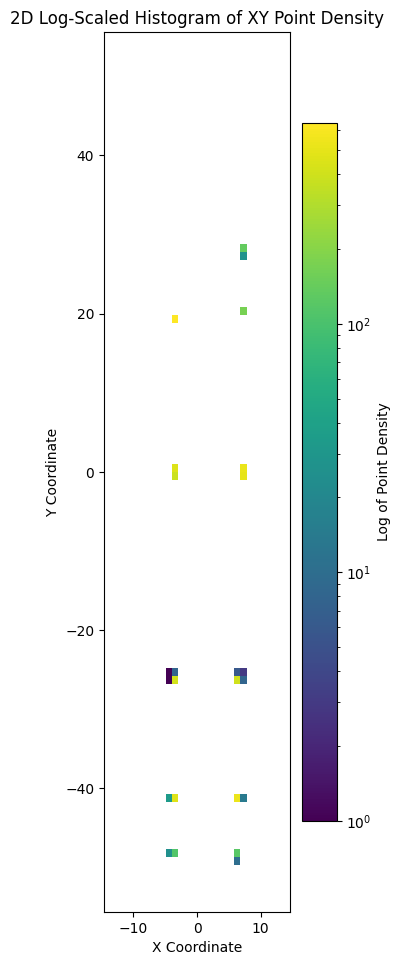

In [4]:
# Step 1: Generate point clouds for the selected categories
# selected_categories = ["11_RAILING", "12_RWP", "7_COLUMN"]
selected_categories = ["12_RWP"]
pcd_dict = p.generate_toy_pcds(categories=selected_categories)

# Step 2: Extract point clouds and sample points
sampled_point_clouds = []
for category in selected_categories:
    if category in pcd_dict:
        # Extract point cloud data from the Open3D PointCloud object
        sampled_pcd = pcd_dict[category]
        sampled_points = np.asarray(sampled_pcd.points)  # Convert to NumPy array
        sampled_point_clouds.append(sampled_points)

# Step 3: Collapse the point clouds to the XY plane and combine them
xy_points = np.vstack([points[:, :2] for points in sampled_point_clouds])

# Step 4: Compute the AABB (axis-aligned bounding box) across all meshes using get_aabb_all_meshes
aabb_all_meshes = p.get_aabb_all_meshes()  # This will use your provided function

# Extract the min and max bounds for the XY plane from the AABB
min_x, min_y = aabb_all_meshes['min'][:2]  # Use only the first two components (XY)
max_x, max_y = aabb_all_meshes['max'][:2]  # Use only the first two components (XY)

# Calculate the range of the AABB for both axes
range_x = max_x - min_x
range_y = max_y - min_y

# Step 5: Determine the number of bins for each axis to make square cells
desired_bin_width = 1  # Desired bin width (adjust this to control the size of each bin)
num_bins_x = int(np.ceil(range_x / desired_bin_width))
num_bins_y = int(np.ceil(range_y / desired_bin_width))

# Step 6: Generate a 2D log-scaled histogram of point density in the XY plane with scaled plot dimensions
plt.figure(figsize=(3, 3 * (range_y / range_x)))  # Aspect ratio based on AABB

plt.hist2d(
    xy_points[:, 0], xy_points[:, 1], 
    bins=[num_bins_x, num_bins_y],  # Use calculated number of bins for square cells
    range=[[min_x, max_x], [min_y, max_y]],  # Set histogram boundaries to match the AABB across all meshes
    cmap='viridis',
    norm=LogNorm()  # Apply logarithmic normalization to the color scale
)
plt.colorbar(label='Log of Point Density')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Log-Scaled Histogram of XY Point Density')

# Adjust plot limits to match the AABB
plt.xlim(min_x, max_x)
plt.ylim(min_y, max_y)

plt.show()